In [1]:
import torch 
import torch.nn as nn
import torchvision
from torchvision import models
from torch.autograd import Variable
import torchvision.transforms as transforms
import numpy as np
from sklearn import metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


train_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = True,
                                          transform = transforms.ToTensor(),
                                          download = True)

test_dataset = torchvision.datasets.MNIST(root = '../input/',
                                           train = False,
                                          transform = transforms.ToTensor())

In [2]:
batch_size = 100
learning_rate = 0.0003
num_epochs = 5

In [3]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle = False)

In [4]:
model = models.shufflenet_v2_x1_0(pretrained= True)

for param in model.parameters():
    param.require_grad = False


In [5]:
for param in model.parameters():
    param.require_grad = False

fc = nn.Sequential(
    nn.Linear(1024,10)
)

model.classifier = fc

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [7]:
padding = Variable(torch.zeros(100, 2, 28, 28))

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 1.9148
Epoch [1/5], Step [200/600], Loss: 0.6000
Epoch [1/5], Step [300/600], Loss: 0.5760
Epoch [1/5], Step [400/600], Loss: 0.5787
Epoch [1/5], Step [500/600], Loss: 0.3602
Epoch [1/5], Step [600/600], Loss: 0.4652
Epoch [2/5], Step [100/600], Loss: 0.4593
Epoch [2/5], Step [200/600], Loss: 0.1327
Epoch [2/5], Step [300/600], Loss: 0.2084
Epoch [2/5], Step [400/600], Loss: 0.1401
Epoch [2/5], Step [500/600], Loss: 0.1780
Epoch [2/5], Step [600/600], Loss: 0.1195
Epoch [3/5], Step [100/600], Loss: 0.0303
Epoch [3/5], Step [200/600], Loss: 0.2183
Epoch [3/5], Step [300/600], Loss: 0.1597
Epoch [3/5], Step [400/600], Loss: 0.0580
Epoch [3/5], Step [500/600], Loss: 0.0519
Epoch [3/5], Step [600/600], Loss: 0.2049
Epoch [4/5], Step [100/600], Loss: 0.1230
Epoch [4/5], Step [200/600], Loss: 0.1037
Epoch [4/5], Step [300/600], Loss: 0.0152
Epoch [4/5], Step [400/600], Loss: 0.0335
Epoch [4/5], Step [500/600], Loss: 0.0386
Epoch [4/5], Step [600/600], Loss:

In [8]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)
    print(correct)
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

9747
Test Accuracy of the model on the 10000 test images: 97.47 %


In [9]:
confusion_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size= 10000, shuffle = False)

padding = Variable(torch.zeros(10000, 2, 28, 28))

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in confusion_loader:
        images = torch.cat((images, padding), 1)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    pred = predicted.to('cpu')
    lb = labels.to('cpu')
    pred = np.array(pred)
    lb = np.array(lb)

[[ 973    0    1    0    1    1    2    2    0    0]
 [   0 1130    1    0    0    0    2    0    2    0]
 [   2    0 1015    1    2    0    1    6    4    1]
 [   0    0    5  983    0   11    0    5    4    2]
 [   0    0    0    0  956    0    1    4    4   17]
 [   1    1    0   16    0  868    1    2    3    0]
 [   4    3    2    1    5    3  937    0    3    0]
 [   0    6    8    7    4    1    0  987    3   12]
 [   6    1    6    4    3    4    1    5  937    7]
 [   2    4    2    6    5    3    1   15   10  961]]


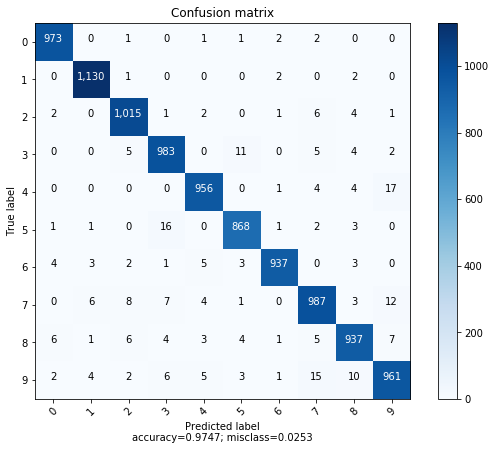

None


In [13]:
from cm_helper import plot_confusion_matrix

conf_matrix = metrics.confusion_matrix(lb, pred)
print(conf_matrix)
print(plot_confusion_matrix(conf_matrix,normalize =False,target_names=[0,1,2,3,4,5,6,7,8,9]))

In [12]:
print(f"The Accuracy : { 100 * metrics.accuracy_score(lb, pred)}")
print(f"The Precision : {100 * metrics.precision_score(lb, pred, average= 'weighted')}")
print(f"The Recall : {100 * metrics.recall_score(lb, pred, average= 'weighted')}")
print(f"The F1 Score : {100 *metrics.f1_score(lb, pred, average = 'weighted')}")

The Accuracy : 97.47
The Precision : 97.46893783381859
The Recall : 97.47
The F1 Score : 97.46807908289844
